In [3]:
%load_ext autoreload
%autoreload 2

import torch
from text3d2video.rendering import render_depth_map
import numpy as np
from text3d2video.util import read_obj_with_uvs
from text3d2video.utilities.camera_placement import (
    cam_view_prompt,
    turntable_extrinsics,
)
from pytorch3d.renderer import FoVPerspectiveCameras

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# read mesh
from text3d2video.utilities.camera_placement import front_facing_extrinsics


device = "cuda"
mesh_path = "data/meshes/mixamo-human.obj"
mesh, verts_uvs, faces_uvs = read_obj_with_uvs(mesh_path, device=device)

# setup cams
n_frames = 10
dist = 10.5
elev = 30
angles = np.linspace(-40, 50, n_frames, endpoint=False)
R, T = turntable_extrinsics(dists=dist, angles=angles, elevs=elev)

z = 7
R, T = front_facing_extrinsics(zs=z, xs=[-0.11,0.11])

frame_cams = FoVPerspectiveCameras(R=R, T=T, device="cuda", fov=10)
frame_meshes = mesh.extend(len(frame_cams))

# prompt suffixes
prompt_suffixes = [f", {cam_view_prompt(a, 0)} view" for a in angles]

/home/jorge/miniconda3/envs/thesis4/lib/python3.9/site-packages/pytorch3d/io/obj_io.py:546: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


In [6]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim = AnimationArtifact.from_wandb_artifact_tag('ymca:latest')
frame_indices = anim.frame_indices(20)

# frame_indices = torch.linspace(30, 45, 10, dtype=int)
# print(frame_indices)

frame_cams, frame_meshes = anim.load_frames(frame_indices)
verts_uvs, faces_uvs = anim.uv_data()

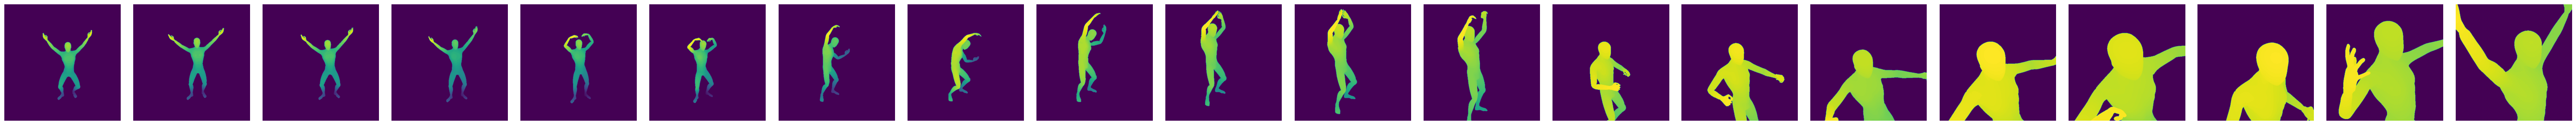

In [7]:
from text3d2video.utilities.ipython_utils import display_ims

depths = render_depth_map(frame_meshes, frame_cams)
display_ims(depths)

In [8]:
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_util import pil_frames_to_clip

display_vid(pil_frames_to_clip(depths))

In [9]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

name = 'ymca_20'
new_anim = AnimationArtifact.create_empty_artifact(name)
new_anim.write_frames(frame_cams, frame_meshes)
new_anim.write_uv_data(verts_uvs, faces_uvs)
new_anim.log_standalone()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: romeu. Use `wandb login --relogin` to force relogin


wandb: Adding directory to artifact (/tmp/local_artifacts/animation/ymca_20)... Done. 0.1s


In [7]:
import wandb_util.wandb_util as wbu


@wbu.wandb_run(job_type="asdf")
def fun(cfg):
    print("a")


fun("a")

wandb init
a
wandb finish
